In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import seaborn as sns

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
import pickle

In [11]:
pd.set_option('display.max_columns', None)

In [13]:
loan_train = pd.read_csv('Loan_Prediction\\Data for Cleaning & Modeling.csv')

C:\Users\Devdutt\AppData\Local\Temp\ipykernel_9500\441035965.py:1: DtypeWarning: Columns (15) have mixed types. Specify dtype option on import or set low_memory=False.
  loan_train = pd.read_csv('Loan_Prediction\\Data for Cleaning & Modeling.csv')


In [14]:
loan_train.head(2)

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,X11,X12,X13,X14,X15,X16,X17,X18,X19,X20,X21,X22,X23,X24,X25,X26,X27,X28,X29,X30,X31,X32
0,11.89%,54734.0,80364.0,"$25,000","$25,000","$19,080",36 months,B,B4,NaN,< 1 year,RENT,85000.0,VERIFIED - income,Aug-09,Due to a lack of personal finance education an...,debt_consolidation,Debt consolidation for on-time payer,941xx,CA,19.48,0.0,Feb-94,0.0,NaN,NaN,10.0,0.0,28854.0,52.10%,42.0,f
1,10.71%,55742.0,114426.0,"$7,000","$7,000",$673,36 months,B,B5,CNN,< 1 year,RENT,65000.0,not verified,May-08,Just want to pay off the last bit of credit ca...,credit_card,Credit Card payoff,112xx,NY,14.29,0.0,Oct-00,0.0,NaN,NaN,7.0,0.0,33623.0,76.70%,7.0,f


### Column Descriptions

In [15]:
loan_metadata = pd.read_csv('Loan_Prediction\\Metadata.csv')
loan_metadata

,Variable,Definition
0,X1,Interest Rate on the loan
1,X2,A unique id for the loan.
2,X3,A unique id assigned for the borrower.
3,X4,Loan amount requested
4,X5,Loan amount funded
5,X6,Investor-funded portion of loan
6,X7,Number of payments (36 or 60)
7,X8,Loan grade
8,X9,Loan subgrade
9,X10,Employer or job title (self-filled)


In [16]:
loan_train.shape

(400000, 32)

In [17]:
loan_train.dtypes

X1      object
X2     float64
X3     float64
X4      object
X5      object
X6      object
X7      object
X8      object
X9      object
X10     object
X11     object
X12     object
X13    float64
X14     object
X15     object
X16     object
X17     object
X18     object
X19     object
X20     object
X21    float64
X22    float64
X23     object
X24    float64
X25    float64
X26    float64
X27    float64
X28    float64
X29    float64
X30     object
X31    float64
X32     object
dtype: object

In [18]:
loan_train.isnull().sum() *100 / loan_train.shape[0]

X1     15.25250
X2      0.00025
X3      0.00025
X4      0.00025
X5      0.00025
X6      0.00025
X7      0.00025
X8     15.31750
X9     15.31750
X10     5.99650
X11     4.38450
X12    15.34025
X13    15.25700
X14     0.00025
X15     0.00025
X16    69.11000
X17     0.00025
X18     0.00475
X19     0.00025
X20     0.00025
X21     0.00025
X22     0.00025
X23     0.00025
X24     0.00025
X25    54.70050
X26    87.21125
X27     0.00025
X28     0.00025
X29     0.00025
X30     0.06675
X31     0.00025
X32     0.00025
dtype: float64

### Handling Nulls

#### Keep only the rows with at least 2 non-NA values.

In [19]:
loan_train.dropna(thresh=2, inplace = True)

#### removing rows with target variable (X1) =  NA

In [20]:
loan_train.dropna(subset=['X1'], inplace = True)

### Data Cleaning

#### Remove % and convert to float

In [21]:
loan_train['X1'] = loan_train['X1'].str.replace(r'[%,]', '', regex = True).str.strip().astype(float)
loan_train['X30'] = loan_train['X30'].str.replace(r'[%,]', '', regex = True).str.strip().astype(float)

#### Remove $ and convert to float

In [22]:
loan_train['X4'] = loan_train['X4'].str.replace(r'[$,]', '', regex = True).str.strip().astype(float)
# Loan amount requested
loan_train['X5'] = loan_train['X5'].str.replace(r'[$,]', '', regex = True).str.strip().astype(float)
# Loan amount funded
loan_train['X6'] = loan_train['X6'].str.replace(r'[$,]', '', regex = True).str.strip().astype(float)
# Investor-funded portion of loan

#### Droppping X2, X3 since they are IDs and can't be used for prediction

In [23]:
loan_train.drop(columns = ['X2','X3'], inplace = True)

In [24]:
loan_train.shape

(338989, 30)

### Feature Mining and EDA

#### Interest Rate on the loan (Target column)

count    338989.000000
mean         13.946289
std           4.377945
min           5.420000
25%          10.990000
50%          13.680000
75%          16.780000
max          26.060000
Name: X1, dtype: float64


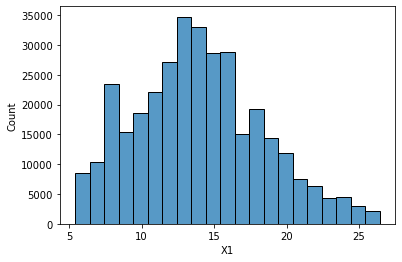

In [25]:
print(loan_train['X1'].describe())
sns.histplot(loan_train['X1'], binwidth=1)
plt.show()

#### Loan amount requested

count    338989.000000
mean      14276.968353
std        8252.264104
min         500.000000
25%        8000.000000
50%       12000.000000
75%       20000.000000
max       35000.000000
Name: X4, dtype: float64


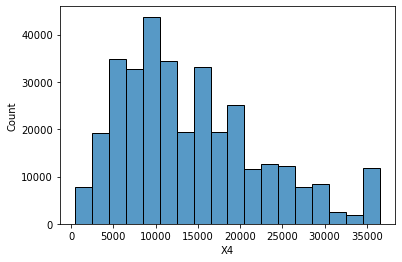

In [26]:
print(loan_train['X4'].describe())
sns.histplot(loan_train['X4'], binwidth=2000)
plt.show()

#### Number of payments (36 or 60)

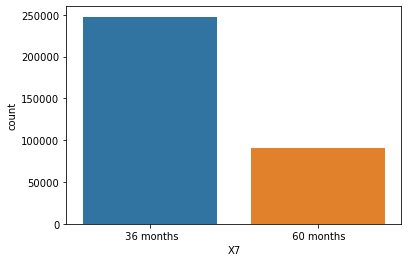

In [27]:
sns.countplot(x='X7',data = loan_train)
plt.show()

#### Loan grade

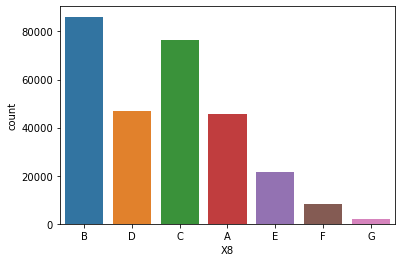

In [28]:
sns.countplot(x='X8',data = loan_train)
plt.show()

In [29]:
loan_train.dropna(subset=['X8','X9'], inplace = True)

#### Number of years employed (Cleaned)

In [30]:
loan_train['X11'] = loan_train['X11'].str.replace(r'[<+years?]', '', regex = True).str.strip()
loan_train['X11'] = loan_train['X11'].fillna('0')
loan_train['X11'] = loan_train['X11'].str.strip().astype(int)

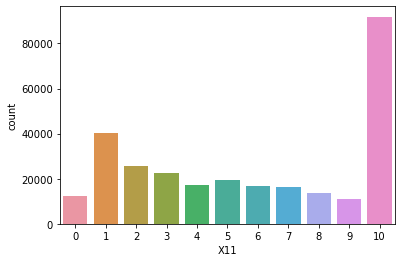

In [31]:
sns.countplot(x='X11',data = loan_train)
plt.show()

#### Home ownership status (placed smaller categories in the 'other' bucket)

In [32]:
loan_train['X12'] = loan_train['X12'].str.replace('NONE','OTHER')
loan_train['X12'] = loan_train['X12'].str.replace('ANY','OTHER')
loan_train['X12'] = loan_train['X12'].fillna('OTHER')

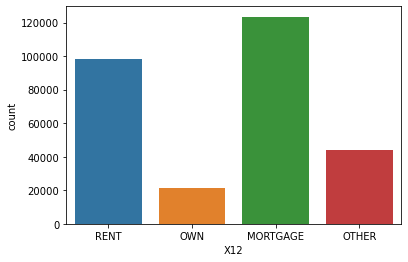

In [33]:
sns.countplot(x='X12',data = loan_train)
plt.show()

#### Annual income of borrower (Had 15% null values, replaced with median)

In [34]:
loan_train['X13'].fillna(int(loan_train['X13'].median()), inplace=True)

<AxesSubplot:xlabel='X13'>

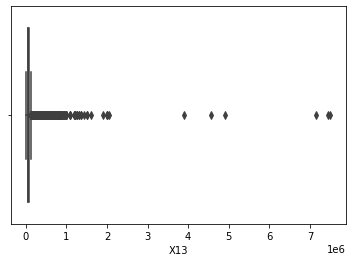

In [35]:
sns.boxplot(x='X13',data=loan_train)

#### Deleting outliers: annual income greater than $1M

In [36]:
loan_train = loan_train[loan_train['X13']<1000000]

#### Income verified, not verified

In [37]:
loan_train['X14'] = loan_train['X14'].str.replace('VERIFIED - income source','VERIFIED - income')

In [38]:
round(loan_train['X14'].value_counts(normalize = True, dropna=False)*100,2)

VERIFIED - income    68.12
not verified         31.88
Name: X14, dtype: float64

#### Loan Issue Year

In [39]:
loan_train['issue_year'] = '20'+loan_train['X15'].str[-2:]

In [40]:
loan_train['issue_year'] = loan_train['issue_year'].apply(lambda x: x if x in ['2012','2013','2014'] else 'older')

In [41]:
loan_train['issue_year'].value_counts(normalize = True)

2014     0.429729
2013     0.336364
2012     0.133614
older    0.100293
Name: issue_year, dtype: float64

#### Loan category, as provided by borrower

In [42]:
loan_train['X17'] = loan_train['X17'].apply(lambda x: x if x in ['debt_consolidation','credit_card'] else 'others')

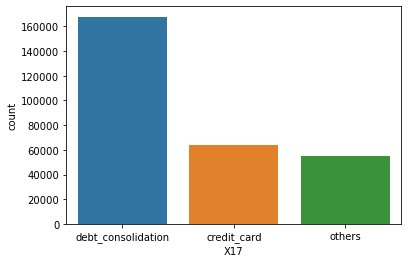

In [43]:
sns.countplot(x='X17',data = loan_train)
plt.show()

#### State of borrower


In [44]:
loan_train['X20'] = loan_train['X20'].apply(lambda x: x if x in ['CA','NY','TX','FL'] else 'others')
round(loan_train['X20'].value_counts(normalize = True, dropna=False)*100,2)

others    61.30
CA        15.54
NY         8.62
TX         7.84
FL         6.70
Name: X20, dtype: float64

#### Debt Ratio

count    287088.000000
mean         17.004083
std           7.693860
min           0.000000
25%          11.260000
50%          16.705000
75%          22.500000
max          39.990000
Name: X21, dtype: float64


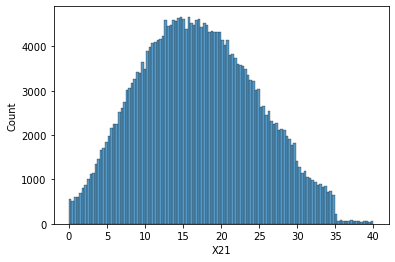

In [45]:
print(loan_train['X21'].describe())
sns.histplot(loan_train['X21'])
plt.show()

#### Deliquence incidents

In [46]:
loan_train['zero_delinquency_incidents'] = loan_train['X22'].apply(lambda x: 1 if x == 0 else 0)

In [47]:
loan_train['zero_delinquency_incidents'].value_counts()

1    237327
0     49761
Name: zero_delinquency_incidents, dtype: int64

#### Number of inquiries by creditors during the past 6 months.

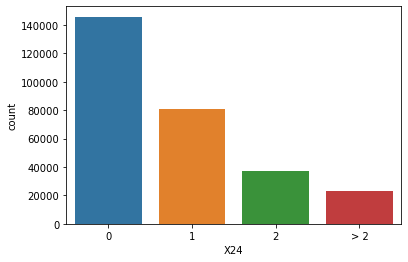

In [48]:
loan_train['X24'] = loan_train['X24'].astype(int)
loan_train['X24'] = loan_train['X24'].apply(lambda x: x if x in [0,1,2] else '> 2')

sns.countplot(x='X24',data = loan_train)
plt.show()

#### Number of open credit lines / total number of credit lines in the borrower's credit file

In [49]:
loan_train['%ocl'] = loan_train['X27']/loan_train['X31']

count    287088.000000
mean          0.483785
std           0.171601
min           0.000000
25%           0.357143
50%           0.464286
75%           0.588235
max           1.750000
Name: %ocl, dtype: float64


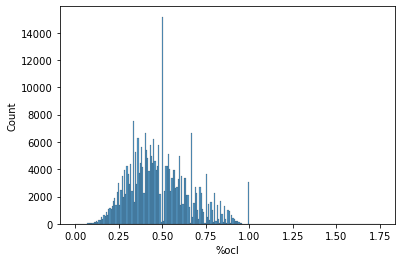

In [50]:
print(loan_train['%ocl'].describe())
sns.histplot(loan_train['%ocl'])
plt.show()

#### Number of derogatory public records


In [51]:
loan_train['no_derogatory_pr'] = loan_train['X28'].apply(lambda x: 1 if x == 0 else 0)

#### Total credit revolving balance

<AxesSubplot:xlabel='X29', ylabel='Count'>

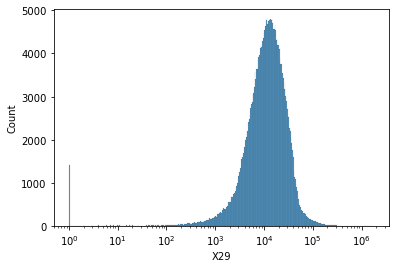

In [52]:
sns.histplot(loan_train['X29']+1, log_scale = True)

#### Revolving line utilization rate

<AxesSubplot:xlabel='X30', ylabel='Density'>

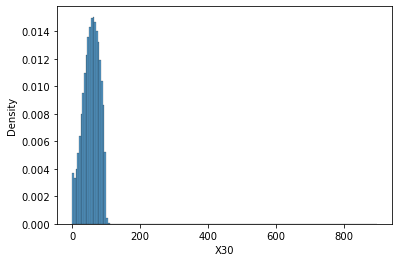

In [53]:
loan_train['X30'].fillna(int(loan_train['X30'].median()), inplace=True)
sns.histplot(loan_train['X30'], binwidth=5, stat="density")

#### The initial listing status of the loan.

In [54]:
round(loan_train['X32'].value_counts(normalize = True)*100,2)
# The initial listing status of the loan. Possible values are W, F

f    68.61
w    31.39
Name: X32, dtype: float64

In [55]:
loan_train.drop(columns = ['X10','X15','X16','X18','X19','X22','X23','X25','X26','X27','X31','X28'], inplace = True)

---

#### Converting categorical columns to dummy variables

In [56]:
loan_train = pd.get_dummies(loan_train, columns=['X7','X8','X9','X12','X14','X17','X20','X24','X32','issue_year','zero_delinquency_incidents','no_derogatory_pr'])

In [57]:
numerical = ['X1','X4','X5','X6','X11','X13','X21','X29','X30','%ocl']

#### Checking Correlation

<AxesSubplot:>

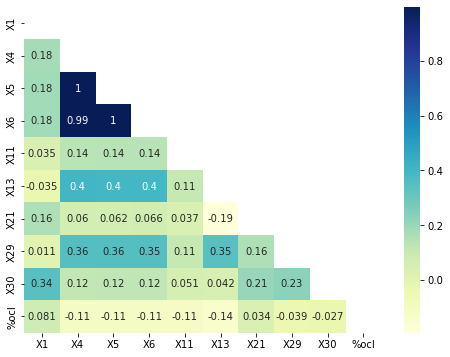

In [58]:
plt.figure(figsize = (8,6))
mask = np.triu(np.ones_like(loan_train[numerical].corr(), dtype=bool))
sns.heatmap(loan_train[numerical].corr(), annot=True, cmap="YlGnBu", mask=mask)

We observe that X4, X5 and X6 are highly correlated, dropping X5 and X6


In [59]:
loan_train.drop(columns = ['X5','X6'], inplace = True)

#### Scaling the numerical features

In [60]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
numerical = ['X1','X4','X11','X13','X21','X29','X30','%ocl']

loan_train = pd.DataFrame(data = loan_train)
loan_train[numerical] = scaler.fit_transform(loan_train[numerical])

In [61]:
loan_train.head(2)

,X1,X4,X11,X13,X21,X29,X30,%ocl,X7_ 36 months,X7_ 60 months,X8_A,X8_B,X8_C,X8_D,X8_E,X8_F,X8_G,X9_A1,X9_A2,X9_A3,X9_A4,X9_A5,X9_B1,X9_B2,X9_B3,X9_B4,X9_B5,X9_C1,X9_C2,X9_C3,X9_C4,X9_C5,X9_D1,X9_D2,X9_D3,X9_D4,X9_D5,X9_E1,X9_E2,X9_E3,X9_E4,X9_E5,X9_F1,X9_F2,X9_F3,X9_F4,X9_F5,X9_G1,X9_G2,X9_G3,X9_G4,X9_G5,X12_MORTGAGE,X12_OTHER,X12_OWN,X12_RENT,X14_VERIFIED - income,X14_not verified,X17_credit_card,X17_debt_consolidation,X17_others,X20_CA,X20_FL,X20_NY,X20_TX,X20_others,X24_0,X24_1,X24_2,X24_> 2,X32_f,X32_w,issue_year_2012,issue_year_2013,issue_year_2014,issue_year_older,zero_delinquency_incidents_0,zero_delinquency_incidents_1,no_derogatory_pr_0,no_derogatory_pr_1
0,-0.469526,1.299326,-1.324587,0.324070,0.321805,0.702096,-0.177563,-1.431752,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,1,0,1
1,-0.739110,-0.880560,-1.324587,-0.148757,-0.352760,0.961272,0.857647,3.008226,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,1,0,1,0,1


### Modeling

#### Splitting dataframe into target variable and feature set

In [62]:
X = loan_train.iloc[:,1:]
y = loan_train.iloc[:,0]

In [63]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.8,
                                                    test_size=0.2, random_state=0)

#### Function to train a model and return train and test R2 and RMSE

In [67]:
def train_predict(learner, X_train, y_train, X_test, y_test, random_state=0):
    
    results = {}
    
    # Fit the learner to the training data
    learner = learner.fit(X_train, y_train)
    
    # Get the predictions on the test set(X_test) and the training set(X_train)
    predictions_test = learner.predict(X_test)
    predictions_train = learner.predict(X_train)
    
    results['Model'] = learner.__class__.__name__
    
    # Compute accuracy on the training set
    results['Train R2'] = round(r2_score(y_train, predictions_train),4)
        
    # Compute accuracy on test set
    results['Test R2'] = round(r2_score(y_test, predictions_test),4)
    
    # Compute F-score on the training set
    results['Train MSE'] = round(mean_squared_error(y_train, predictions_train),4)
        
    #Compute F-score on the test set
    results['Test MSE'] = round(mean_squared_error(y_test, predictions_test),4)


    # Return the results
    return results

In [68]:
lr = LinearRegression()
dtr = DecisionTreeRegressor()
xgb = XGBRegressor()
gbr = GradientBoostingRegressor()
abr = AdaBoostRegressor()
rf = RandomForestRegressor()

In [69]:
model_list = [lr, dtr, gbr, abr, rf, xgb]
results = []

for model in model_list:
    results.append(train_predict(model, X_train, y_train, X_test, y_test, random_state=0))
    
model_df = pd.DataFrame(results, columns = ['Model','Train R2','Test R2','Train MSE',
                                            'Test MSE']).sort_values('Test R2', ascending = False)

In [70]:
model_df

,Model,Train R2,Test R2,Train MSE,Test MSE
5,XGBRegressor,0.9908,0.9898,0.0092,0.0101
4,RandomForestRegressor,0.9985,0.9894,0.0015,0.0105
2,GradientBoostingRegressor,0.9844,0.9847,0.0156,0.0152
0,LinearRegression,0.9797,0.9800,0.0203,0.0199
1,DecisionTreeRegressor,1.0000,0.9778,0.0000,0.0221
3,AdaBoostRegressor,0.8109,0.8105,0.1893,0.1885


#### Hyperparameter tuning

In [74]:
param_grid = {"n_estimators" : [50, 100, 150],
             "learning_rate" : [0.1,0.01],
             'max_depth': [4,6,8]}

In [75]:
rgrid = RandomizedSearchCV(xgb, param_grid, cv = 3, scoring="neg_mean_squared_error", n_jobs=-2, verbose=3)
rgrid.fit(X,y)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


RandomizedSearchCV(cv=3,
                   estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                          callbacks=None, colsample_bylevel=1,
                                          colsample_bynode=1,
                                          colsample_bytree=1,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          gamma=0, gpu_id=-1,
                                          grow_policy='depthwise',
                                          importance_type=None,
                                          interaction_constraints='',
                                          learning_rate=0.3000...
                                          max_cat_to_onehot=4, max_delta_step=0,
                                          max_depth=6, max_leaves=0,

In [76]:
print(f"Best parameters: {rgrid.best_params_}")

Best parameters: {'n_estimators': 100, 'max_depth': 8, 'learning_rate': 0.1}
Best mean squared error: 0.03826489827383456


#### Feature Importance

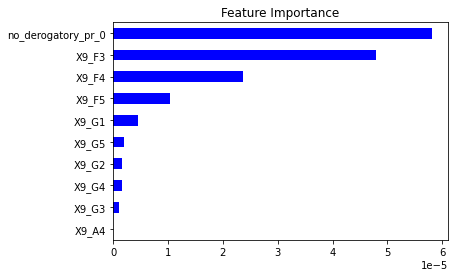

In [82]:
feature_importance = rgrid.best_estimator_.feature_importances_
importances_rf = pd.Series(feature_importance,index = X.columns)
sorted_importances_rf = importances_rf.sort_values()
sorted_importances_rf[0:10].plot(kind='barh', color='blue')
plt.title('Feature Importance')
plt.show()

#### Saving the pickle file

In [84]:
with open('tuned_regressor.pkl','wb') as f:
    pickle.dump(rgrid,f)

## Holdout Test set

In [85]:
loan_test = pd.read_csv('Loan_Prediction\\Holdout for Testing.csv')

In [86]:
loan_metadata = pd.read_csv('Loan_Prediction\\Metadata.csv')

In [87]:
loan_test.isnull().sum() *100 / loan_test.shape[0]

X1     100.00000
X2       0.00000
X3       0.00000
X4       0.00000
X5       0.00000
X6       0.00000
X7       0.00000
X8       0.00000
X9       0.00000
X10      5.49250
X11      5.47750
X12      0.00000
X13      0.00000
X14      0.00000
X15      0.00000
X16     99.98125
X17      0.00000
X18      0.00000
X19      0.00000
X20      0.00000
X21      0.00000
X22      0.00000
X23      0.00000
X24      0.00000
X25     48.38000
X26     82.70125
X27      0.00000
X28      0.00000
X29      0.00000
X30      0.03750
X31      0.00000
X32      0.00000
dtype: float64

#### Performing same operations as training set

In [88]:
loan_test['X30'] = loan_test['X30'].str.replace(r'[%,]', '', regex = True).str.strip().astype(float)
loan_test['X4'] = loan_test['X4'].str.replace(r'[$,]', '', regex = True).str.strip().astype(float)
loan_test['X5'] = loan_test['X5'].str.replace(r'[$,]', '', regex = True).str.strip().astype(float)
loan_test['X6'] = loan_test['X6'].str.replace(r'[$,]', '', regex = True).str.strip().astype(float)

loan_test['X11'] = loan_test['X11'].str.replace(r'[<+years?]', '', regex = True).str.strip()
loan_test['X11'] = loan_test['X11'].fillna('0')
loan_test['X11'] = loan_test['X11'].str.strip().astype(int)

loan_test['X12'] = loan_test['X12'].str.replace('NONE','OTHER')
loan_test['X12'] = loan_test['X12'].str.replace('ANY','OTHER')
loan_test['X12'] = loan_test['X12'].fillna('OTHER')

loan_test['X13'].fillna(int(loan_test['X13'].median()), inplace=True)

loan_test['X14'] = loan_test['X14'].str.replace('VERIFIED - income source','VERIFIED - income')

loan_test['issue_year'] = '20'+loan_test['X15'].str[-2:]
loan_test['issue_year'] = loan_test['issue_year'].apply(lambda x: x if x in ['2012','2013','2014'] else 'older')

loan_test['X17'] = loan_test['X17'].apply(lambda x: x if x in ['debt_consolidation','credit_card'] else 'others')

loan_test['X20'] = loan_test['X20'].apply(lambda x: x if x in ['CA','NY','TX','FL'] else 'others')

loan_test['zero_delinquency_incidents'] = loan_test['X22'].apply(lambda x: 1 if x == 0 else 0)

loan_test['X24'] = loan_test['X24'].astype(int)
loan_test['X24'] = loan_test['X24'].apply(lambda x: x if x in [0,1,2] else '> 2')

loan_test['%ocl'] = loan_test['X27']/loan_test['X31']

loan_test['no_derogatory_pr'] = loan_test['X28'].apply(lambda x: 1 if x == 0 else 0)

loan_test['X30'].fillna(int(loan_test['X30'].median()), inplace=True)

loan_test.drop(columns = ['X5','X6','X3','X10','X15','X16','X18','X19','X22','X23','X25','X26','X27','X31','X28'], inplace = True)

#### Converting categorical columns to dummy variables

In [89]:
loan_test = pd.get_dummies(loan_test, columns=['X7','X8','X9','X12','X14','X17','X20','X24','X32','issue_year','zero_delinquency_incidents','no_derogatory_pr'])

In [90]:
X_test_holdout = loan_test.iloc[:,2:]

In [91]:
#Found missing columns by 
a = X_test.columns.tolist()
b = X_test_holdout.columns.tolist()
c = [token for token in b if token not in a]

In [92]:
X_test_holdout['X12_OTHER'] = 0
X_test_holdout['issue_year_2012'] = 0
X_test_holdout['issue_year_2013'] = 0
X_test_holdout['issue_year_2014'] = 0

In [93]:
#To get in the same order
X_test_holdout2 = X_test_holdout[X_test.columns.tolist()]

#### Loading the pickle file

In [94]:
with open('tuned_regressor.pkl', 'rb') as f:
    tuned_model = pickle.load(f)

In [95]:
predictions = tuned_model.predict(X_test_holdout2)

In [96]:
predict = pd.DataFrame({'X2':loan_test['X2'],
                        'X1':predictions})

In [97]:
predict.to_csv('Loan Prediction results from Devdutt Sharma.csv', index = False)